# Data Exploration

In [286]:
import pandas as pd
import numpy as np

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

## Settings

In [287]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

colour_palette = sns.color_palette("hls", 9)

## Load Data

In [288]:
data = joblib.load('../data/00_data.pkl')

In [289]:
data.head()

,date,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [290]:
data.shape

(8760, 14)

In [291]:
data.columns

Index(['date', 'rented_bike_count', 'hour', 'temperature', 'humidity',
       'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation',
       'rainfall', 'snowfall', 'seasons', 'holiday', 'functioning_day'],
      dtype='object')

## Initial Analysis

### Duplicated Rows

In [292]:
num_dup_rows = data.duplicated().sum()

print(f'Number of duplicated rows: {num_dup_rows}')

Number of duplicated rows: 0


### Unique Values

In [293]:
unique_values = data.nunique().to_frame(name = 'number of unique values')

unique_values['proportion of unique values over total rows'] = unique_values['number of unique values'] / data.shape[0]

unique_values

,number of unique values,proportion of unique values over total rows
date,365,0.041667
rented_bike_count,2166,0.247260
hour,24,0.002740
temperature,546,0.062329
humidity,90,0.010274
wind_speed,65,0.007420
visibility,1789,0.204224
dew_point_temperature,556,0.063470
solar_radiation,345,0.039384
rainfall,61,0.006963


### Datatypes

In [294]:
data.dtypes

date                     datetime64[ns]
rented_bike_count                 int64
hour                              int64
temperature                     float64
humidity                          int64
wind_speed                      float64
visibility                        int64
dew_point_temperature           float64
solar_radiation                 float64
rainfall                        float64
snowfall                        float64
seasons                          object
holiday                          object
functioning_day                  object
dtype: object

## Response Analysis

### Define response

In [295]:
RESPONSE = 'rented_bike_count'

### Response Distribution

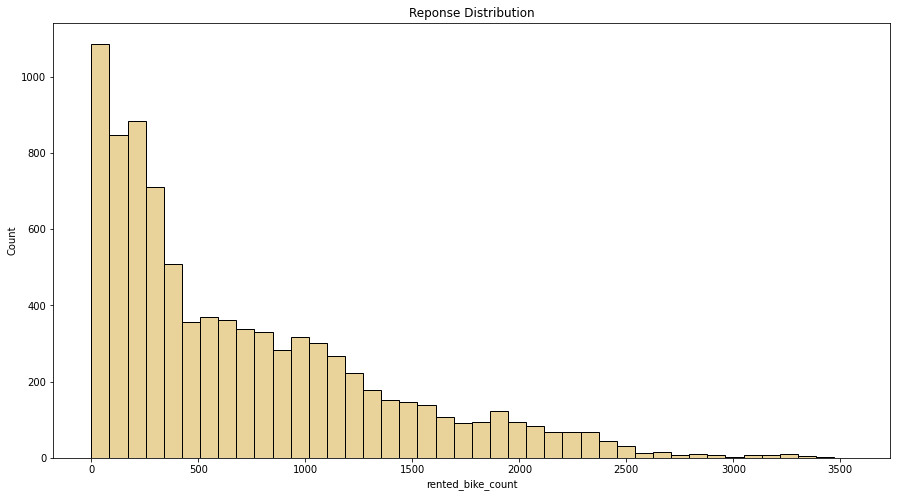

In [296]:
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize = (15,8))

ax = sns.histplot(data=data, x = RESPONSE, alpha = 0.6, color=colour_palette[1])
ax.set_title('Reponse Distribution')
plt.show()

Conclusion: there is a positive skew in the response

### Response over time

In [297]:
print(f'Min Date: {data.date.min().strftime("%d/%m/%Y")}')
print(f'Max Date: {data.date.max().strftime("%d/%m/%Y")}')

Min Date: 12/01/2017
Max Date: 11/12/2018


### Level 1: Monthly

In [298]:
data['month'] = data.date.dt.to_period('M')

In [299]:
mean_month_response = data[[RESPONSE, 'month']].groupby('month', as_index = False).mean()

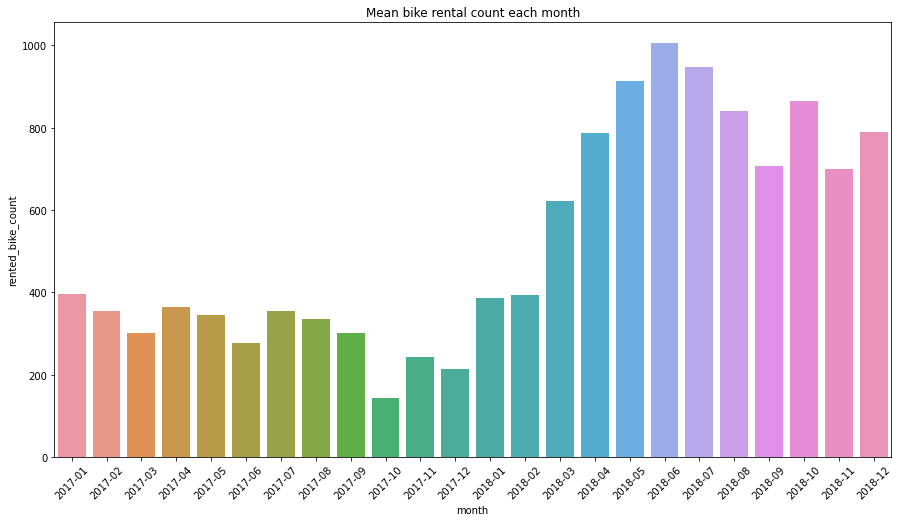

In [300]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (15, 8))

ax1 = sns.barplot(data=mean_month_response, x = 'month', y=RESPONSE)
ax1.set_title('Mean bike rental count each month')
plt.xticks(rotation = 45)
plt.show()

As we can see there seems to be a split in the data between 2017 and 2018 - is there anything more going on here?

### Monthly value counts

In [301]:
data['month'].value_counts().sort_index()

2017-01     24
2017-02     24
2017-03     24
2017-04     24
2017-05     24
2017-06     24
2017-07     24
2017-08     24
2017-09     24
2017-10     24
2017-11     24
2017-12    480
2018-01    720
2018-02    648
2018-03    720
2018-04    696
2018-05    720
2018-06    696
2018-07    720
2018-08    720
2018-09    696
2018-10    720
2018-11    696
2018-12    264
Freq: M, Name: month, dtype: int64

We see here that there is a lot more data entries from December 2017 onwards. Coupled with the above bar chart, we can also see that this split is matched with an average value split i.e. there are more entries and there are a greater number of hires for each entry on average.

In [302]:
del data['month']

### Splitting the data into the two years

In [303]:
KEYDATE = datetime(day = 1, month = 12, year = 2017)

data_012117 = data[data.date < KEYDATE]
data_onwards = data[data.date >= KEYDATE]

In [304]:
data.shape, data_012117.shape, data_onwards.shape

((8760, 14), (264, 14), (8496, 14))

Due to the imbalance in both data count and average value, pre-01/12/2017 is unrepresentative of the current state of the feature and so we should exclude them. Further, since this only accounts for 264 data points, this shouldn't have a significant effect on our datasize.

We will now use `data_onwards` for further analysis.

## Feature Analysis

### Define features

In [305]:
date_features = ['date']

target_feature = ['rented_bike_count']

numeric_features = ['hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation', 'rainfall', 'snowfall']

object_features = ['seasons', 'holiday', 'functioning_day']

In [306]:
all_fields = date_features + target_feature + numeric_features + object_features

if len(all_fields) == data_onwards.shape[1]:
    print('All features accounted for.')

All features accounted for.


### Numeric Features

In [307]:
num_summary = data_onwards[numeric_features].describe().T
num_summary['Null'] = data_onwards[numeric_features].isnull().sum()
num_summary['Unique'] =data_onwards[numeric_features].nunique()
num_summary

,count,mean,std,min,25%,50%,75%,max,Null,Unique
hour,8496.0,11.500000,6.922594,0.0,5.75,11.50,17.250,23.00,0,24
temperature,8496.0,13.310428,11.853957,-17.8,4.20,14.40,22.700,39.40,0,546
humidity,8496.0,58.302613,20.318619,0.0,43.00,57.00,74.000,98.00,0,90
wind_speed,8496.0,1.721022,1.026314,0.0,0.90,1.50,2.300,7.40,0,65
visibility,8496.0,1436.208686,605.569561,27.0,937.00,1691.00,2000.000,2000.00,0,1779
dew_point_temperature,8496.0,4.492903,12.976407,-30.6,-4.00,5.70,15.125,27.20,0,556
solar_radiation,8496.0,0.580056,0.877407,0.0,0.00,0.01,0.950,3.52,0,345
rainfall,8496.0,0.152189,1.144558,0.0,0.00,0.00,0.000,35.00,0,60
snowfall,8496.0,0.071339,0.427403,0.0,0.00,0.00,0.000,8.80,0,49


#### Distributions

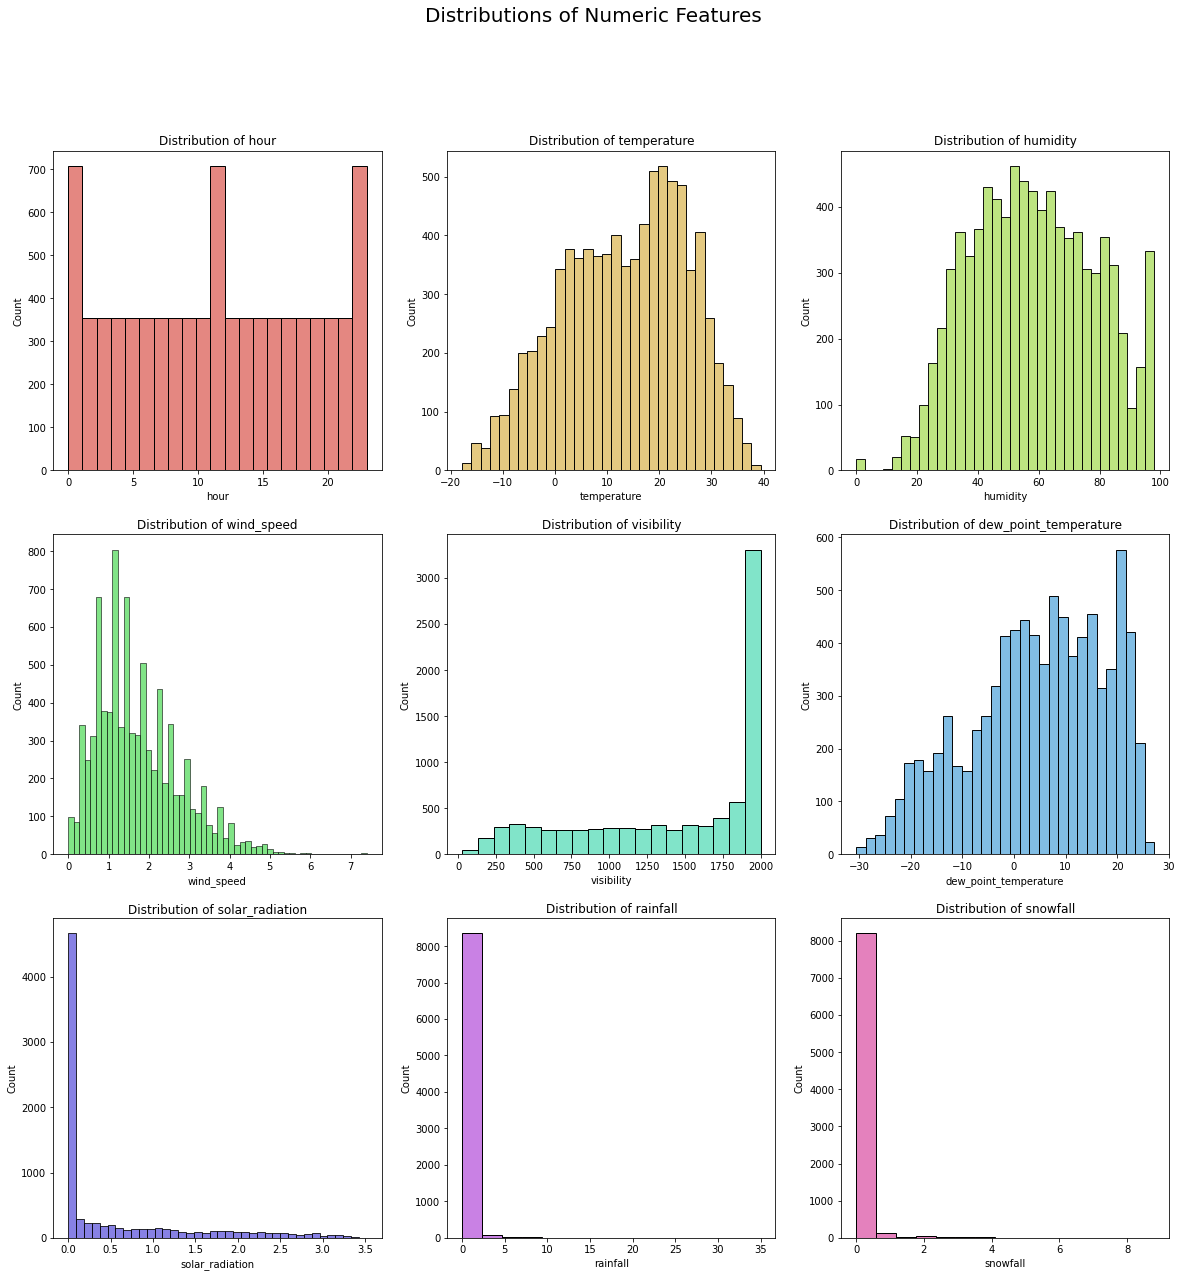

In [308]:
fig3, ax3 = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 20))

for idx, col in enumerate(numeric_features):
    x, y = idx // 3, idx % 3
    sns.histplot(
        ax = ax3[x, y],
        data=data_onwards,
        x = col, color= colour_palette[idx]
    ).set(title = f'Distribution of {col}')

fig3.suptitle('Distributions of Numeric Features', fontsize = 20)
plt.show()

There are two things to jump out from these distributions:
- High skew in `solar_radiation`, `rainfall`, `snowfall` and `visibility`
- There seem to be spikes in `hour` - why this this the case?

In [309]:
# Answer Qs... should we be putting skew features into binary feature?

#### Correlation

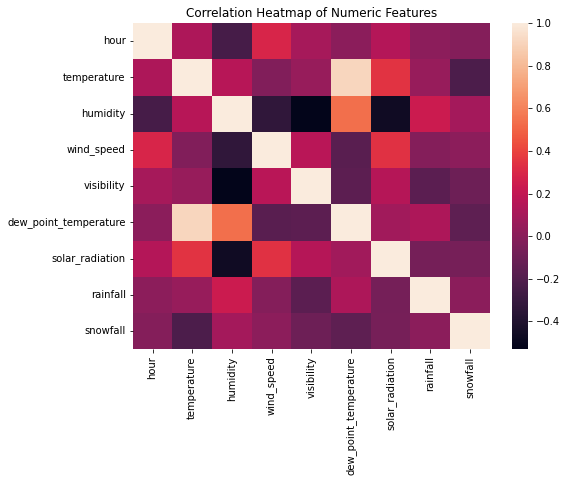

In [310]:
correlation = data_onwards[numeric_features].corr()

fig4, ax4 = plt.subplots(figsize = (8, 6))

sns.heatmap(
    ax=ax4,
    data = correlation,
    xticklabels = correlation.columns,
    yticklabels = correlation.columns
).set(title = 'Correlation Heatmap of Numeric Features')

plt.show()

High correlation (~0.91) between `temperature` and `dew_point_temperature`. Due to this correlation, and since there is also a light correlation with `humidity`, we will remove `dew_point_temperature` for modelling.

### Object Features

In [311]:
obj_summary = data_onwards[object_features].describe().T
obj_summary['Null'] = data_onwards[object_features].isnull().sum()
obj_summary

,count,unique,top,freq,Null
seasons,8496,4,Spring,2208,0
holiday,8496,2,No Holiday,8064,0
functioning_day,8496,2,Yes,8201,0


No missing values, few unique values.

#### Distributions

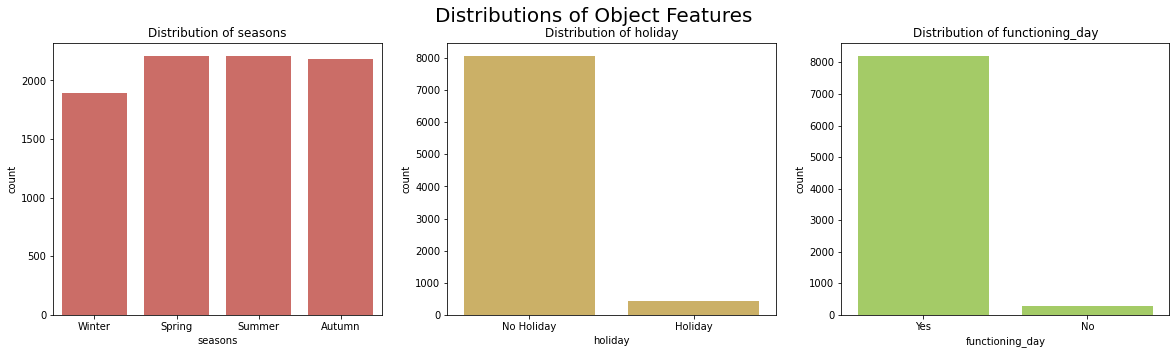

In [312]:
fig5, ax5 = plt.subplots(nrows=1, ncols=3, figsize = (20, 5))

for idx, col in enumerate(object_features):
    sns.countplot(
        ax = ax5[idx],
        data = data_onwards,
        x = col,
        color=colour_palette[idx]
    ).set(title = f'Distribution of {col}')

fig5.suptitle('Distributions of Object Features', fontsize = 20)
plt.show()

There is quite a severe imbalance between the `holiday` and `functioning_day` features. However, this shouldn't be an issue, but something to keep an eye on to avoid overfitting.

#### Influence that `holiday` and `functioning_day` has on `response`

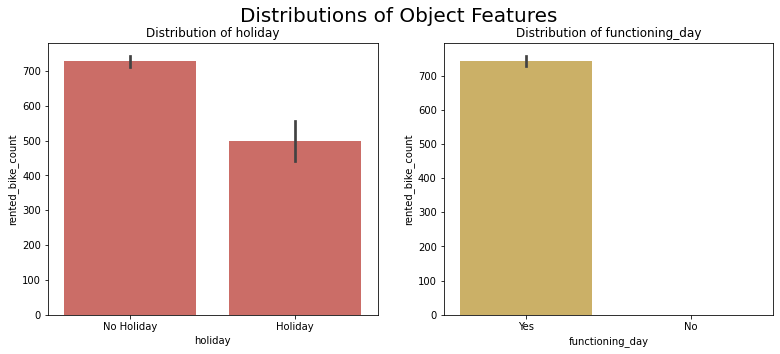

In [313]:
fig6, ax6 = plt.subplots(nrows=1, ncols=2, figsize = (13, 5))

for idx, col in enumerate(['holiday', 'functioning_day']):
    sns.barplot(
        ax = ax6[idx],
        data = data_onwards,
        x = col,
        y = RESPONSE,
        color=colour_palette[idx]
    ).set(title = f'Distribution of {col}')

fig6.suptitle('Distributions of Object Features', fontsize = 20)
plt.show()

`holiday` does seem to be influencial so something we should keep. However, `functioning_day` is clearly a feature to remove.

### Remove harmful features

In [314]:
data_onwards.drop(columns=['dew_point_temperature', 'functioning_day'], inplace= True)

/opt/anaconda3/envs/itai-dev/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## save .pkl

In [315]:
joblib.dump(data_onwards, '../data/01_data.pkl')

['../data/01_data.pkl']